c:\MyData\abm\main.py:124: FutureWarning: The new PropertyLayer and _PropertyGrid classes experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1932
  patch_layer = PropertyLayer("patch_type", width = self.grid.width, height = self.grid.height, default_value=-1, dtype=int)


[[2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]
Value_High    0.877722
Value_Low     0.036241
dtype: float64


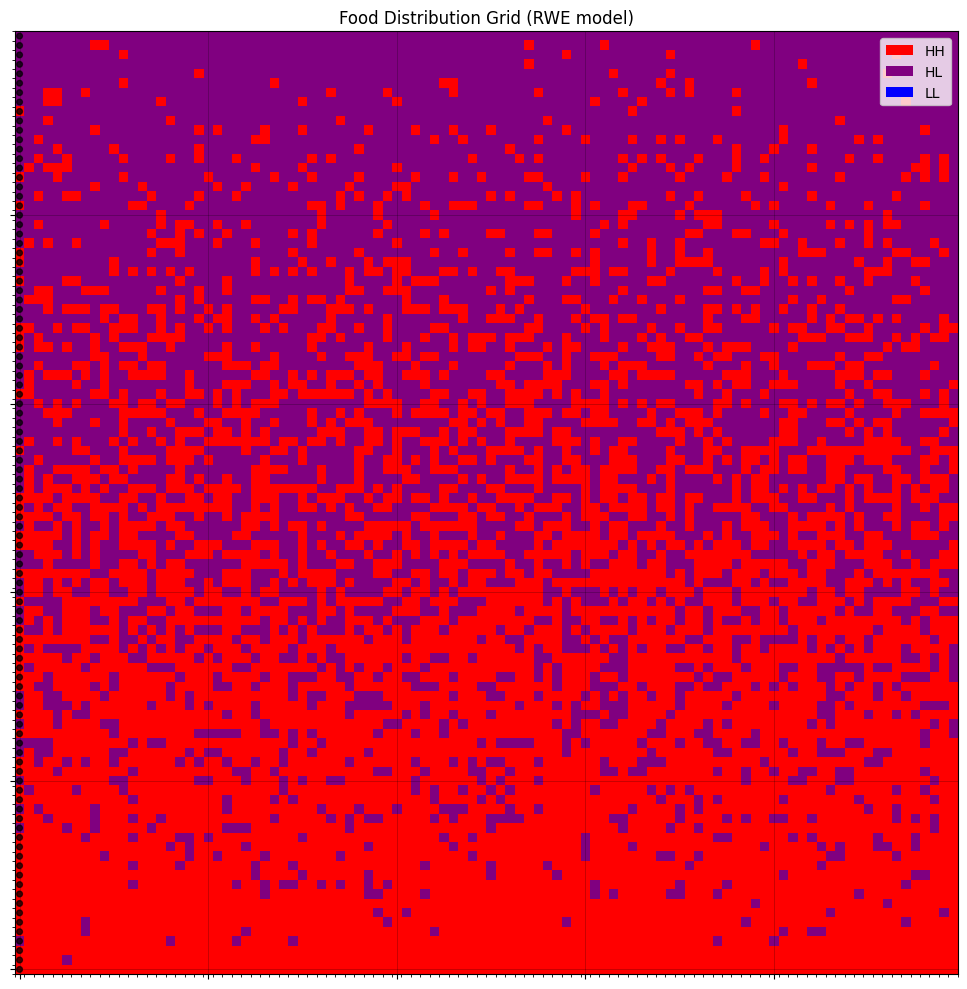

In [1]:
from main import LearningModel, visualize_grid

#Here you can run a model once with different learning models and food environments. 
#You can either use 'TD', 'RW', or 'RWE' at learning_model.
#You can pick 'random', 'gradient_l', 'gradient_h', 'weekday' as food environments.
#You can also fill in an integer (e.g., 1) after seed to make the simulation reproducible.
#Epsilon represents the probability that an agent chooses the other option regardless of preference. For example, when dieting.
#Theta represents the H to L ratio in the random food environment.

m = LearningModel(N=100, width=100, height=100, learning_model='RWE', distribute_patches = 'gradient_h', seed = None, epsilon = 0.05, theta = 4)

for i in range(100):
    m.step()

df = m.datacollector.get_agent_vars_dataframe()
df1 = df.reset_index()

visualize_grid(m)

data = df.reset_index() 
filtered_data = data[data["Step"] == 99]  # Filter rows where Step equals 99
average_values = filtered_data[['Value_High', 'Value_Low']].mean()  # Calculate mean for the selected columns

print(average_values)

Text(0, 0.5, 'V')

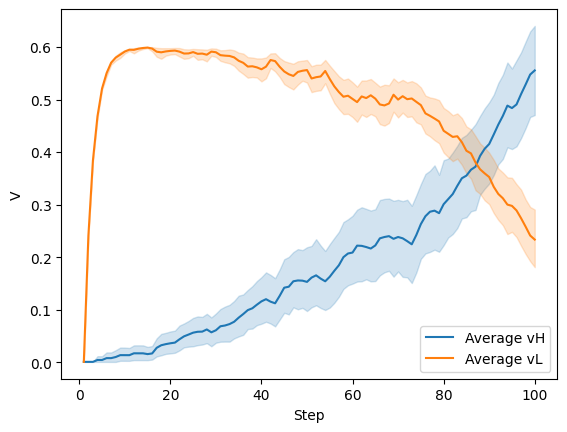

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

#Plot the results of the single run.

sns.lineplot(df1, x = "Step", y = "Value_High", label = "Average vH")
sns.lineplot(df1, x = "Step", y = "Value_Low", label = "Average vL")
plt.ylabel('V')

#### Batch run

In [6]:
from main import LearningModel
from tqdm import tqdm 
import pandas as pd

#With the batch_run function you can run the model in 6 different configurations as often as you like. This will return a dataframe called "data".
#The dataframe contains time-series data for all agents for every single run in the 6 different configurations.

iterations = 10
learning_models = ["TD", "RWE"]
distribute_patches = ["random", "gradient_h", "gradient_l"]

def batch_run():
    all_data = []
    
    total_runs = len(learning_models) * len(distribute_patches) * iterations
    progress_bar = tqdm(total=total_runs, desc="Batch Running")

    for learning_model in learning_models:
        for distribute_patch in distribute_patches:
            batch_run_data = []
            for i in range(iterations):
                model = LearningModel(N=100, width=100, height=100, learning_model=learning_model, distribute_patches=distribute_patch)
                
                # Run the model for a fixed number of steps
                for _ in range(100):
                    model.step()
                
                # Get model data
                m_data = model.datacollector.get_agent_vars_dataframe()
                m_data['Run'] = i
                m_data['Learning_Model'] = learning_model
                m_data['Distribute_Patches'] = distribute_patch
                batch_run_data.append(m_data)

                progress_bar.update(1)
            
            # Concatenate the data for this configuration
            batch_run_data = pd.concat(batch_run_data)
            all_data.append(batch_run_data)
    
    # Concatenate all configurations
    all_data = pd.concat(all_data)
    
    return all_data

# Run the custom batch run function
data = batch_run()

Batch Running: 100%|██████████| 60/60 [00:08<00:00,  7.34it/s]


In [7]:
data = data.reset_index()

#### Initial model comparison in random environment

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_random_env_rw_td(data, legend_labels, custom_palette):
    # Filter data for the 'random' environment and 'RW' and 'TD' learning models
    df_filtered = data[(data['Distribute_Patches'] == 'random') & 
                       (data['Learning_Model'].isin(['RW', 'TD']))]

    # Melt the DataFrame to long format for easier plotting with seaborn
    df_melted = df_filtered.melt(id_vars=['Step', 'Learning_Model'], 
                                 value_vars=['Value_High', 'Value_Low'], 
                                 var_name='Food', value_name='Value')

    plt.rcParams.update({
        'font.size': 18,          # general font size
        'axes.titlesize': 20,     # title font size
        'axes.labelsize': 18,     # x and y label font size
        'xtick.labelsize': 18,    # x tick label font size
        'ytick.labelsize': 18,    # y tick label font size
        'legend.fontsize': 18     # legend font size
    })

    # Plot the data using seaborn
    plt.figure(figsize=(12, 8))
    
    sns.lineplot(data=df_melted, x='Step', y='Value', hue='Food', 
                 style='Learning_Model', estimator='mean', errorbar=('ci', 80), palette= custom_palette)
    
    plt.xlabel('Steps')
    plt.ylabel('Average Anticipated Reward')

    # Customizing the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = [legend_labels.get(label, label) for label in labels]
    plt.legend(handles, new_labels, title='')

    plt.show()

# Example of how to use the function with custom legend labels
legend_labels = {
    'Value_High': 'H',
    'Value_Low': 'L',
    'Learning_Model': 'Learning Model',
    'Food': 'Food Object'
}

custom_palette = {
    'Value_High': '#d62728',
    'Value_Low': '#1f77b4'

}

# Assuming 'data' is the DataFrame with your results
plot_random_env_rw_td(data, legend_labels, custom_palette)


#### Different environments and learning models

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({
        'font.size': 18,          # general font size
        'axes.titlesize': 20,     # title font size
        'axes.labelsize': 18,     # x and y label font size
        'xtick.labelsize': 18,    # x tick label font size
        'ytick.labelsize': 18,    # y tick label font size
        'legend.fontsize': 18     # legend font size
    })

def plot_results(data, distribute_patch, legend_labels, custom_palette):
    # Filter data for the specific distribute_patch
    df_filtered = data[data['Distribute_Patches'] == distribute_patch]
    
    df_melted = df_filtered.melt(id_vars=['Step', 'Learning_Model'], 
                                 value_vars=['Value_High', 'Value_Low'], 
                                 var_name='Food', value_name='Value')

    # Plot the data using seaborn
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_melted, x='Step', y='Value', hue = 'Food', style='Learning_Model', palette = custom_palette, estimator='mean', errorbar=('ci', 80), legend = False)
    plt.xlabel('Steps')
    plt.ylabel('Anticipated Reward Value')
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = [legend_labels.get(label, label) for label in labels]
    #plt.legend(handles, new_labels, title='', loc = "lower center", bbox_to_anchor = (0.5, -0.35) , ncol = 2, frameon = False)

    plt.show()

# Example of how to use the function with custom legend labels
legend_labels = {
    'Value_High': 'H',
    'Value_Low': 'L',
    'Learning_Model': 'Learning Model'
}

custom_palette = {
    'Value_High': '#d62728',
    'Value_Low': '#1f77b4'

}

# Plot results for each distribute_patch
for distribute_patch in distribute_patches:
    plot_results(data, distribute_patch, legend_labels, custom_palette)

In [12]:
from main import LearningModel
import pandas as pd
from tqdm import tqdm

# Define the parameters to vary
learning_model = "RWE"
distribute_patch = "random"
thetas = [0.25, 0.5, 1.0, 2.0, 4.0]  #H to L ratio
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  #"dieting" 

def batch_run_2():
    results = []
    
    for theta in thetas:
        for epsilon in epsilons:
            for i in tqdm(range(10), desc=f"Running {learning_model} with theta={theta}, epsilon={epsilon}"):
                model = LearningModel(N=100, width=100, height=100, learning_model=learning_model, distribute_patches=distribute_patch, theta=theta, epsilon=epsilon, value_high=0.89, value_low=0.10)
                
                for step in range(1000):
                    model.step()
                
                # Collect data from agents
                for agent in model.schedule.agents:
                    results.append({
                        "Run": i,
                        "Theta": theta,
                        "Epsilon": epsilon,
                        "Value_High": agent.value_high,
                        "Value_Low": agent.value_low,
                    })
    
    return results

df = pd.DataFrame(batch_run_2())

Running RWE with theta=4.0, epsilon=1.0: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


In [2]:
from model import LearningModel
import pandas as pd
from tqdm import tqdm

# Define the parameters to vary
learning_model = "RWE"
distribute_patch = "random"
thetas = [0.25, 0.5, 1.0, 2.0, 4.0]  #H to L ratio
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  #"dieting" 

def batch_run_2():
    results = []
    
    for theta in thetas:
        for epsilon in epsilons:
            for i in tqdm(range(10), desc=f"Running {learning_model} with theta={theta}, epsilon={epsilon}"):
                model = LearningModel(N=100, width=100, height=100, learning_model=learning_model, distribute_patches=distribute_patch, theta=theta, epsilon=epsilon, value_high=0.89, value_low=0.10)
                
                for step in range(100):
                    model.step()
                
                # Collect data from agents
                for agent in model.agents:
                    results.append({
                        "Run": i,
                        "Theta": theta,
                        "Epsilon": epsilon,
                        "Value_High": agent.value_high,
                        "Value_Low": agent.value_low,
                    })
    
    return results

df = pd.DataFrame(batch_run_2())

Running RWE with theta=4.0, epsilon=1.0: 100%|██████████| 10/10 [00:00<00:00, 13.82it/s]


In [3]:
df_avg = df.groupby(["Run", "Epsilon", "Theta"]).mean().reset_index()

In [4]:
# Filter for Theta == 4.0 and Epsilon == 0.10
filtered_data_1 = df_avg[(df_avg["Theta"] == 4.0) & (df_avg["Epsilon"] == 1.0)]

# Filter for Theta == 0.25 and Epsilon == 1.0
filtered_data_2 = df_avg[(df_avg["Theta"] == 0.25) & (df_avg["Epsilon"] == 0.1)]

# Calculate means for both conditions
mean_1 = filtered_data_1[['Value_High', 'Value_Low']].mean()
mean_2 = filtered_data_2[['Value_High', 'Value_Low']].mean()

print(mean_1, mean_2)

Value_High    0.504569
Value_Low     0.494521
dtype: float64 Value_High    0.647996
Value_Low     0.457636
dtype: float64


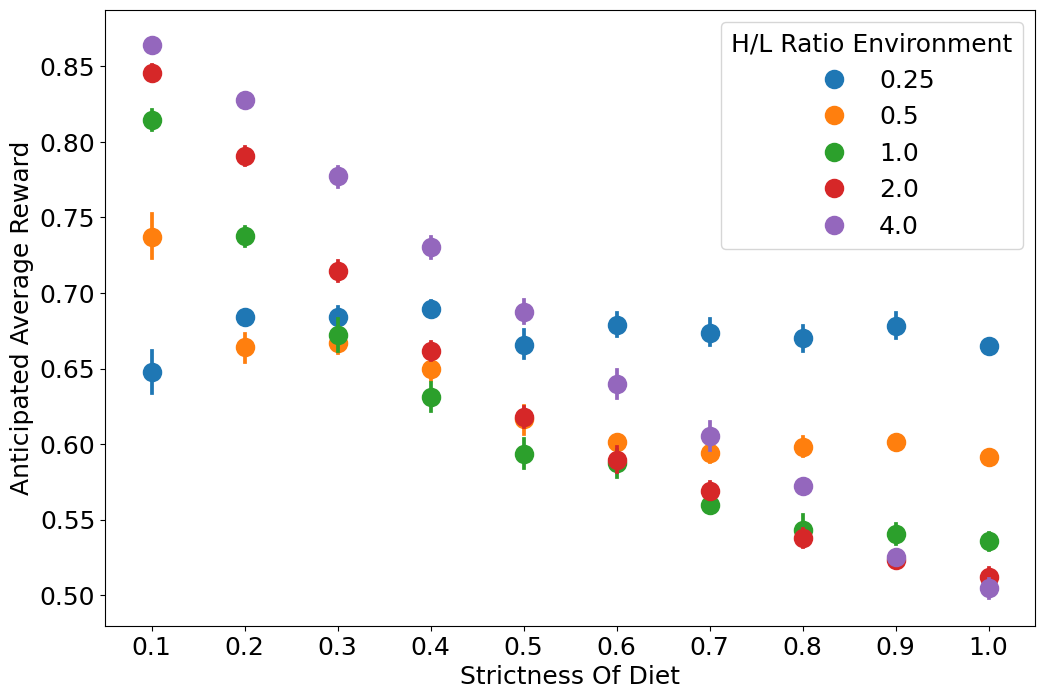

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_results():
    plt.figure(figsize=(12, 8))
    plt.rcParams.update({
        'font.size': 18,          # general font size
        'axes.titlesize': 20,     # title font size
        'axes.labelsize': 18,     # x and y label font size
        'xtick.labelsize': 18,    # x tick label font size
        'ytick.labelsize': 18,    # y tick label font size
        'legend.fontsize': 18     # legend font size
    })
    # Plot Value_High
    sns.pointplot(data=df_avg, x='Epsilon', y='Value_High', hue='Theta', errorbar=('ci', 80), markersize = 12, linestyle = 'none', palette='tab10')
    plt.xlabel('Strictness Of Diet')
    plt.ylabel('Anticipated Average Reward')
    plt.legend(title='H/L Ratio Environment')
    plt.show()

# Plot results
plot_results()

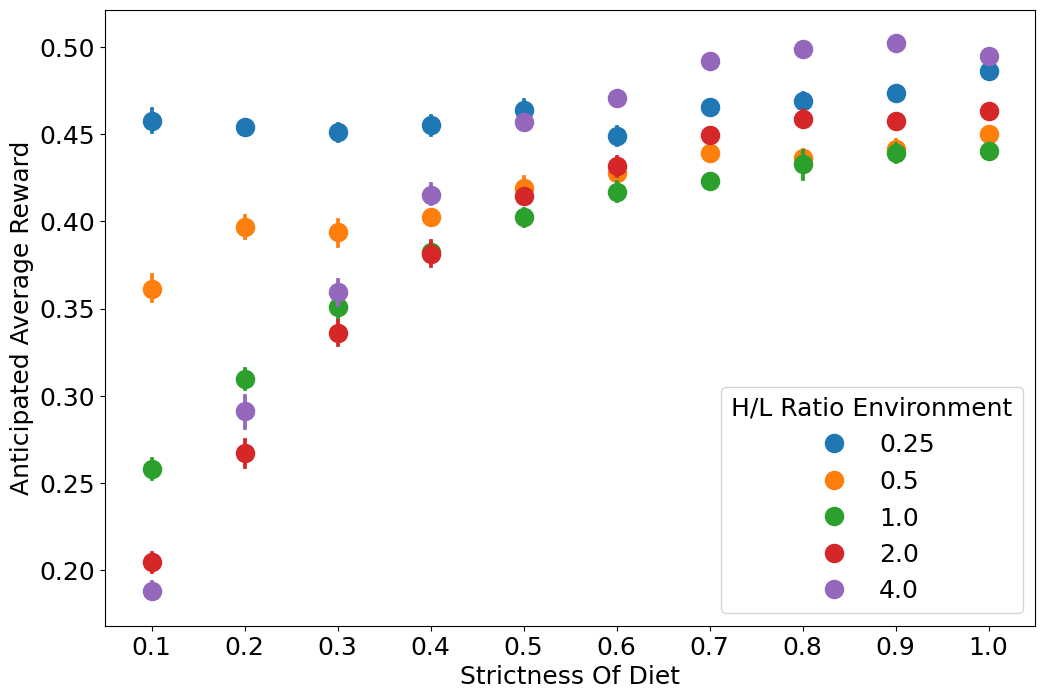

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_results():
    plt.figure(figsize=(12, 8))
    sns.pointplot(data=df_avg, x='Epsilon', y='Value_Low', hue='Theta', errorbar=('ci', 80), markersize = 12, linestyle = 'none', palette='tab10')
    plt.xlabel('Strictness Of Diet')
    plt.ylabel('Anticipated Average Reward')
    plt.legend(title='H/L Ratio Environment')
    plt.rcParams.update({
        'font.size': 18,          # general font size
        'axes.titlesize': 20,     # title font size
        'axes.labelsize': 18,     # x and y label font size
        'xtick.labelsize': 18,    # x tick label font size
        'ytick.labelsize': 18,    # y tick label font size
        'legend.fontsize': 18     # legend font size
    })

    plt.show()

# Plot results
plot_results()
